In [2]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

We want to compare a model trained with epynet and a model trained with dhalsim. <br>
Here is the training schedule:
- 1 episode to fill replay buffer
- 25 episodes of training
- 5 episodes of testing (with the same demand patterns)

In [223]:
folder = 'control_results/'
dhalsim_file = 'train2_results'
epynet_file = 'overflow1'

with open( folder + dhalsim_file, mode='rb') as file:
    dhalsim_results = pd.read_pickle(file)

with open(folder + epynet_file, mode='rb') as file:
    epynet_results = pickle.load(file)
   
results = epynet_results

In [224]:
results['eval']

[{'dsr': 0.5779296500861693,
  'dataset':                                        current_state action  reward  \
  0                          [1.0, 0.0, 0.0, 0.0, 0.0]    [0]     0.0   
  1         [1.0, 0.0, 3.0484917, 3.0480626, 63.36581]    [3]    -1.0   
  2        [1.0, 10.0, 3.4602926, 3.3351293, 86.16946]    [3]     1.0   
  3        [1.0, 300.0, 3.857767, 3.6012354, 86.16498]    [3]     1.0   
  4        [1.0, 600.0, 4.2564244, 3.880619, 86.19056]    [3]     1.0   
  ...                                              ...    ...     ...   
  2036  [7.0, 84900.0, 8.0943775, 5.4939566, 81.89016]    [1]     1.0   
  2037    [7.0, 85200.0, 8.12793, 5.5704756, 82.09905]    [1]     1.0   
  2038   [7.0, 85500.0, 8.218996, 5.7330885, 82.32644]    [1]     1.0   
  2039    [7.0, 85800.0, 8.259965, 5.813349, 82.16351]    [1]     1.0   
  2040      [7.0, 86100.0, 8.333085, 5.94205, 82.2977]    [1]  -100.0   
  
                                           next_state  absorbing_state  \
  0    

In [225]:
DSRs = [results['eval'][i]['dsr'] for i in range(len(dhalsim_results['eval']))]
DSRs

[0.5779296500861693,
 0.5770021842061456,
 0.5772288395683356,
 0.5752139518479142,
 0.5769904644869206]

In [226]:
import seaborn as sns

# Function to plot the heatmap
def plot_model_heatmap(data, index, title='', color=None, annot=False, columns=['action 0', 'action 1', 'action 2', 'action 3']):   
    df = pd.DataFrame(data, index=index, columns=columns)
    
    figure, ax = plt.subplots(figsize=(10,7))
    if color:
        ax = sns.heatmap(df, cmap=color, annot=annot)
    else:
        ax = sns.heatmap(df, annot=annot)
    
    if title:
        ax.set_title(title)

In [227]:
# Method to reduce the dataset to the same length of q_values selecting corresponding samples
def crop_dataset(model, seed):
    
    # Build the boolean list of timestep of q_values which are present also in dataset 
    time_idx = [model[seed]['dataset']['current_state'][i][:2] for i in range(len(model[seed]['dataset']))]
    qs_idx = [model[seed]['q_values'][i][0] for i in range(len(model[seed]['q_values']))]
    bool_idx = [True if time_idx[i] in qs_idx else False for i in range(len(model[seed]['dataset']))]

    # Select which data we want to keep based on the boolean list
    cropped_dataset = model[seed]['dataset'].copy()
    for i in cropped_dataset.index:
        if not bool_idx[i]:
            cropped_dataset.drop(axis=0, index=i, inplace=True)
    return cropped_dataset

In [228]:
cropped_dhalsim = crop_dataset(dhalsim_results['eval'], 0)
cropped_dhalsim['current_state']

0                       [1.0, 0.0, 0.0, 0.0, 0.0]
1                     [1.0, 600.0, 0.0, 0.0, 0.0]
2       [1.0, 1200.0, 3.4799309, 3.051, 85.98483]
3       [1.0, 1800.0, 3.4799309, 3.048, 85.98483]
4        [1.0, 2400.0, 3.833111, 3.048, 85.99654]
                          ...                    
1003       [7.0, 83400.0, 3.048, 3.048, 75.95912]
1004       [7.0, 84000.0, 3.048, 3.048, 75.95912]
1005       [7.0, 84600.0, 3.048, 3.048, 76.50713]
1006       [7.0, 85200.0, 3.048, 3.048, 76.50713]
1008           [1.0, 0.0, 3.048, 3.048, 76.50713]
Name: current_state, Length: 967, dtype: object

In [229]:
len(results['eval'][0]['dataset'])

2041

In [230]:
len(results['eval'][0]['q_values'])

2041

Heatmaps of the Q-values

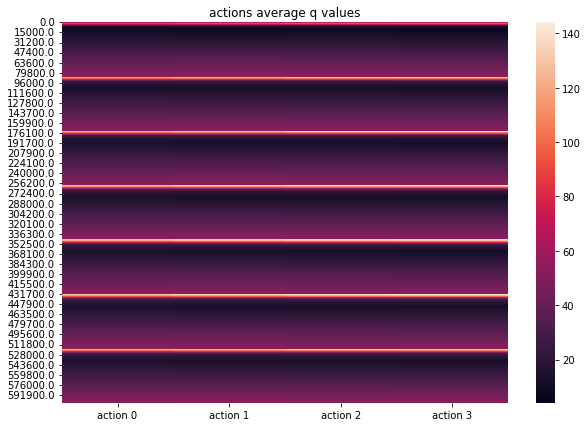

In [261]:
model = results['eval']
seed = 0

qs = [model[seed]['q_values'][i][1] for i in range(len(model[seed]['q_values']))]
#index = [model[seed]['q_values'][i][0][0] for i in range(len(model[seed]['q_values']))]
index = [model[seed]['q_values'][i][0][1] + 86400 * (model[seed]['q_values'][i][0][0] - 1) for i in range(len(model[seed]['q_values']))]

plot_model_heatmap(qs, index, title='actions average q values')

In [232]:
results['eval'][0]['q_values']

[[[1.0, 0.0],
  [5.957472801208496, 4.6161208152771, 4.835025787353516, 4.065567970275879]],
 [[1.0, 0.0],
  [72.6010513305664, 74.358642578125, 76.30425262451172, 77.13487243652344]],
 [[1.0, 10.0],
  [90.73474884033203,
   93.35930633544922,
   95.75682067871094,
   97.06218719482422]],
 [[1.0, 300.0],
  [92.3116226196289, 95.04185485839844, 97.487060546875, 98.81791687011719]],
 [[1.0, 600.0],
  [91.20882415771484, 93.94014739990234, 96.37664794921875, 97.6455078125]],
 [[1.0, 900.0],
  [89.58642578125, 92.29429626464844, 94.709228515625, 95.90238952636719]],
 [[1.0, 1200.0],
  [86.9459228515625, 89.58223724365234, 91.95036315917969, 93.041015625]],
 [[1.0, 1500.0],
  [82.0998764038086, 84.56040954589844, 86.82711791992188, 87.75716400146484]],
 [[1.0, 1800.0],
  [77.13311767578125, 79.41221618652344, 81.5744857788086, 82.34075164794922]],
 [[1.0, 2100.0],
  [71.7075424194336, 73.78349304199219, 75.82997131347656, 76.42037963867188]],
 [[1.0, 2400.0],
  [68.1819839477539, 70.1445922

In [233]:
model = results['eval']
seed = 0
interval = 14400 # one hour
day = 86400

n_intervals = int(day / interval)

avg_q = {str(key): [0, 0, 0, 0] for key in range(n_intervals)}
count_q = {str(key): 0 for key in range(n_intervals)}

for q_step in model[seed]['q_values']:
    mod = str(int(q_step[0][1] // interval))
    avg_q[mod] = [avg_q[mod][i] + q_step[1][i] for i in range(len(avg_q[mod]))]
    count_q[mod] += 1

In [234]:
for i in avg_q.keys():
    avg_q[i] = [avg_q[i][j] / count_q[i] if count_q[i] > 0 else np.NINF  for j in range(4)]

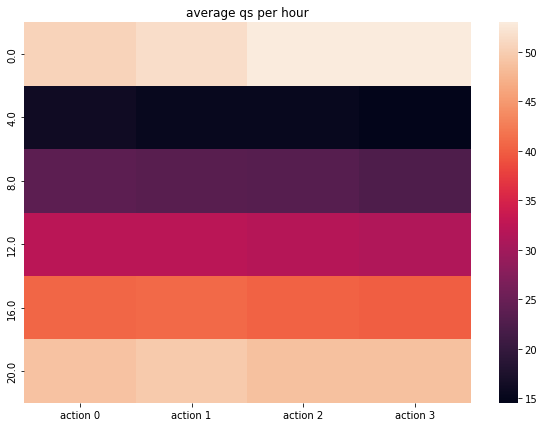

In [235]:
qs = list(avg_q.values())
index = [(0 + interval * i) / 3600 for i in range(n_intervals)]

plot_model_heatmap(qs, index, title='average qs per hour')

Now we want to print how the Q-values are distributed among the different days of the week.

In [236]:
model = results['eval']
seed = 0

avg_q = {str(key): [0, 0, 0, 0] for key in range(1,8)}
count_q = {str(key): 0 for key in range(1,8)}

for q_step in model[seed]['q_values']:
    mod = str(int(q_step[0][0]))
    avg_q[mod] = [avg_q[mod][i] + q_step[1][i] for i in range(len(avg_q[mod]))]
    count_q[mod] += 1

In [237]:
for i in avg_q.keys():
    avg_q[i] = [avg_q[i][j] / count_q[i] if count_q[i] > 0 else np.NINF for j in range(4)]

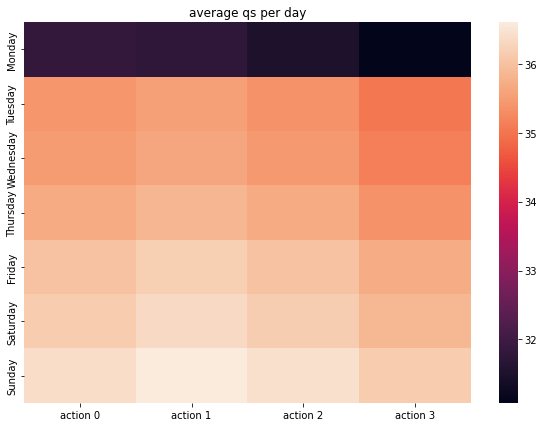

In [238]:
qs = list(avg_q.values())
index = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

plot_model_heatmap(qs, index, title='average qs per day')

Now we want to split in discrete intervals the value of the level of tank 41. We will plot the heatmap of Q-values associated with each interval.

In [239]:
model = results['eval']
seed = 0

tank41_levels = [model[seed]['dataset']['current_state'][i][2] for i in range(1, len(model[seed]['dataset']))]
max_level = max(tank41_levels)
min_level = min(tank41_levels)
n_intervals = 4

print("min level: ", min_level)
print("max level: ", max_level)

interval = (max_level - min_level) / n_intervals

avg_q = {str(key): [0, 0, 0, 0] for key in range(n_intervals + 1)}
count_q = {str(key): 0 for key in range(n_intervals + 1)}

tmp_dataset = crop_dataset(model, seed).iloc[1: , :]

for i, q_step in enumerate(model[seed]['q_values'][1:]):
    mod = str(int((tmp_dataset['current_state'].iloc[i][2] - min_level) // interval))
    avg_q[mod] = [avg_q[mod][j] + q_step[1][j] for j in range(len(avg_q[mod]))]
    count_q[mod] += 1

min level:  3.0468793
max level:  10.565387


In [240]:
count_q

{'0': 1037, '1': 285, '2': 461, '3': 256, '4': 1}

In [241]:
avg_q

{'0': [25389.47375869751,
  24981.039358615875,
  24747.61188030243,
  24079.543969631195],
 '1': [10445.687572479248,
  10490.291010856628,
  10345.951099395752,
  10268.28256893158],
 '2': [21354.38997077942,
  21624.811688423157,
  21270.411007881165,
  21261.16164970398],
 '3': [14768.277118682861,
  15145.462648391724,
  15514.27038192749,
  15587.663522720337],
 '4': [27.05033302307129,
  27.129613876342773,
  27.775165557861328,
  27.29753303527832]}

In [242]:
for i in avg_q.keys():
    avg_q[i] = [avg_q[i][j] / count_q[i] if count_q[i]>0 else np.NINF for j in range(4)]

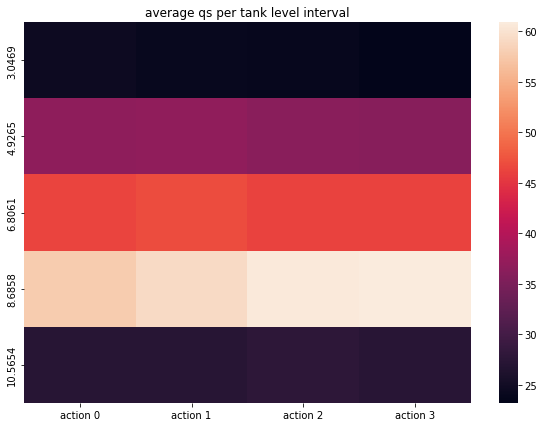

In [243]:
qs = list(avg_q.values())
index = [str(round(min_level + int(key) * interval, 4)) for key in avg_q.keys()]

plot_model_heatmap(qs, index, title='average qs per tank level interval')

Considering one action at time, we want know to see the correlation between different variables in the state space. We are now trying to plot the heatmap to show these results.

In [244]:
# We can compare day_of_the_week and tank41_level for example each action
model = results['eval']
seed = 0

tank41_levels = [model[seed]['dataset']['current_state'][i][2] for i in range(1, len(model[seed]['dataset']))]
max_level = max(tank41_levels)
min_level = min(tank41_levels)
n_intervals = 4

print("min level: ", min_level)
print("max level: ", max_level)

interval = (max_level - min_level) / n_intervals
tmp_dataset = crop_dataset(model, seed).iloc[1:, :]

avg_q_list = []
count_q_list = []

for action in range(4):
    avg_q = {str(key): [0, 0, 0, 0, 0, 0, 0] for key in range(n_intervals + 1)}
    count_q = {str(key): [0, 0, 0, 0, 0, 0, 0] for key in range(n_intervals + 1)}   

    for i, q_step in enumerate(model[seed]['q_values'][1:]):
        mod = str(int((tmp_dataset['current_state'].iloc[i][2] - min_level) // interval))
        day = int(q_step[0][0]) - 1
        avg_q[mod][day] += q_step[1][action]
        count_q[mod][day] += 1
    
    avg_q_list.append(avg_q)
    count_q_list.append(count_q)

min level:  3.0468793
max level:  10.565387


In [245]:
avg_q_list

[{'0': [4580.378887176514,
   3490.888345718384,
   3459.007939338684,
   3481.6523485183716,
   3532.573254585266,
   3420.969988822937,
   3424.0029945373535],
  '1': [1931.127872467041,
   1640.5585308074951,
   1080.5303649902344,
   1326.6319904327393,
   1712.1337547302246,
   1054.7250537872314,
   1699.9800052642822],
  '2': [2723.236457824707,
   2919.892135620117,
   3389.9754600524902,
   3096.6363697052,
   2727.2214374542236,
   3569.131772994995,
   2928.2963371276855],
  '3': [49.706398010253906,
   2248.5890579223633,
   2394.8493061065674,
   2478.693790435791,
   2583.979465484619,
   2472.1374950408936,
   2540.321605682373],
  '4': [0, 0, 0, 0, 27.05033302307129, 0, 0]},
 {'0': [4512.420538425446,
   3432.7504892349243,
   3400.8247537612915,
   3424.570789337158,
   3476.281189918518,
   3365.5448265075684,
   3368.6467714309692],
  '1': [1946.8704242706299,
   1646.7384729385376,
   1080.8574810028076,
   1330.5265712738037,
   1719.8695831298828,
   1056.78291702

In [246]:
count_q_list

[{'0': [183, 144, 143, 143, 144, 140, 140],
  '1': [50, 45, 32, 37, 46, 30, 45],
  '2': [57, 62, 74, 67, 60, 78, 63],
  '3': [1, 40, 42, 44, 43, 43, 43],
  '4': [0, 0, 0, 0, 1, 0, 0]},
 {'0': [183, 144, 143, 143, 144, 140, 140],
  '1': [50, 45, 32, 37, 46, 30, 45],
  '2': [57, 62, 74, 67, 60, 78, 63],
  '3': [1, 40, 42, 44, 43, 43, 43],
  '4': [0, 0, 0, 0, 1, 0, 0]},
 {'0': [183, 144, 143, 143, 144, 140, 140],
  '1': [50, 45, 32, 37, 46, 30, 45],
  '2': [57, 62, 74, 67, 60, 78, 63],
  '3': [1, 40, 42, 44, 43, 43, 43],
  '4': [0, 0, 0, 0, 1, 0, 0]},
 {'0': [183, 144, 143, 143, 144, 140, 140],
  '1': [50, 45, 32, 37, 46, 30, 45],
  '2': [57, 62, 74, 67, 60, 78, 63],
  '3': [1, 40, 42, 44, 43, 43, 43],
  '4': [0, 0, 0, 0, 1, 0, 0]}]

Text(0.5, 1.0, 'action 3 --> days - tank41_level')

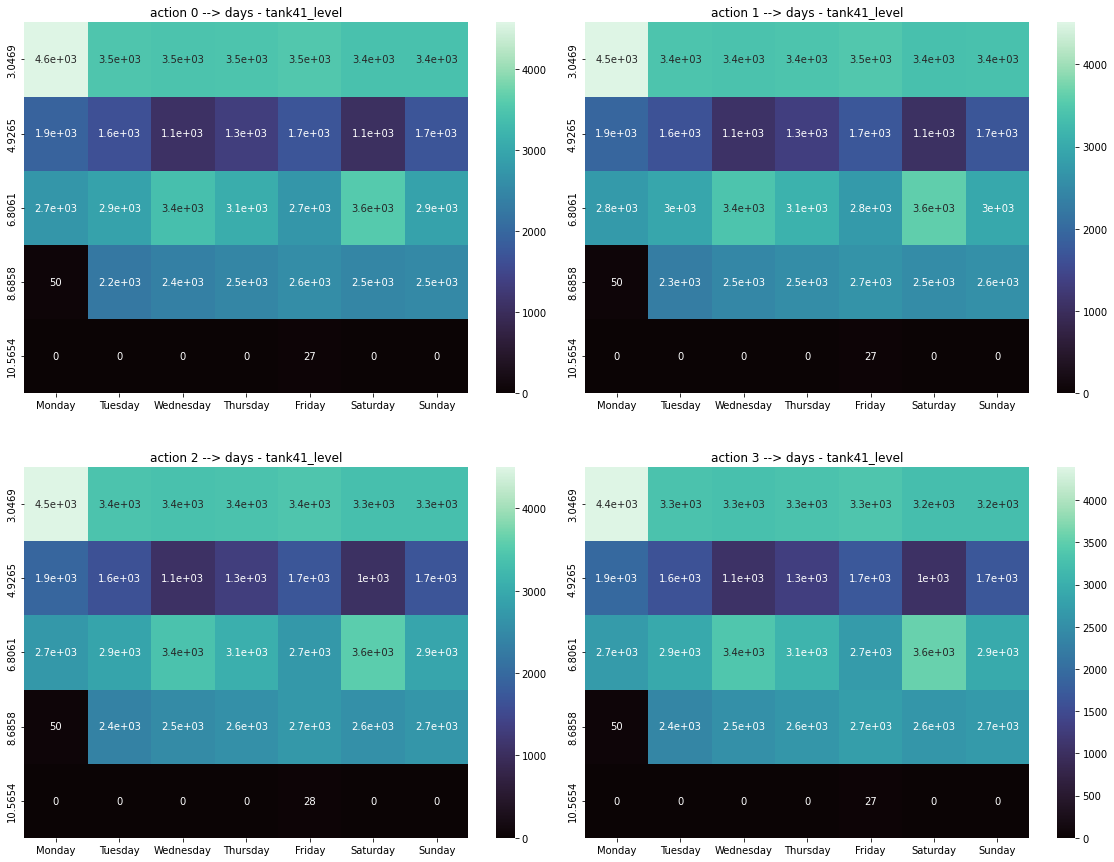

In [247]:
index = [str(round(min_level + int(key) * interval, 4)) for key in avg_q_list[0].keys()]
columns = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

figure, axs = plt.subplots(2, 2, figsize=(20,15))
figure.subplots_adjust(hspace = .2, wspace=.01)

axs = axs.ravel()

for i in range(4):
    qs = list(avg_q_list[i].values())
    df = pd.DataFrame(qs, index=index, columns=columns)
    sns.heatmap(df, ax=axs[i], cmap='mako',annot=True)
       
axs[0].set_title("action 0 --> days - tank41_level")
axs[1].set_title("action 1 --> days - tank41_level")
axs[2].set_title("action 2 --> days - tank41_level")
axs[3].set_title("action 3 --> days - tank41_level")

We want to plot the occurrences of the actions given the tank41 level and the time

In [248]:
# We can compare time and tank41_level for example each action
model = results['eval']
seed = 0

tank41_levels = [model[seed]['dataset']['current_state'][i][2] for i in range(1, len(model[seed]['dataset']))]
max_level = max(tank41_levels)
min_level = min(tank41_levels)

print("min level: ", min_level)
print("max level: ", max_level)

interval = (max_level - min_level) / 8
tmp_dataset = crop_dataset(model, seed).iloc[1:, :]

count_q_list = []

for action in range(4):
    count_q = {str(key): [0] * 24 for key in range(9)}

    for i, q_step in enumerate(model[seed]['q_values'][1:]):
        mod = str(int((tmp_dataset['current_state'].iloc[i][2] - min_level) // interval))
        hour = int(q_step[0][1] // 3600)
        count_q[mod][hour] += 1
    
    count_q_list.append(count_q)

min level:  3.0468793
max level:  10.565387


Text(0.5, 1.0, '#action 3 --> hour - tank41_level')

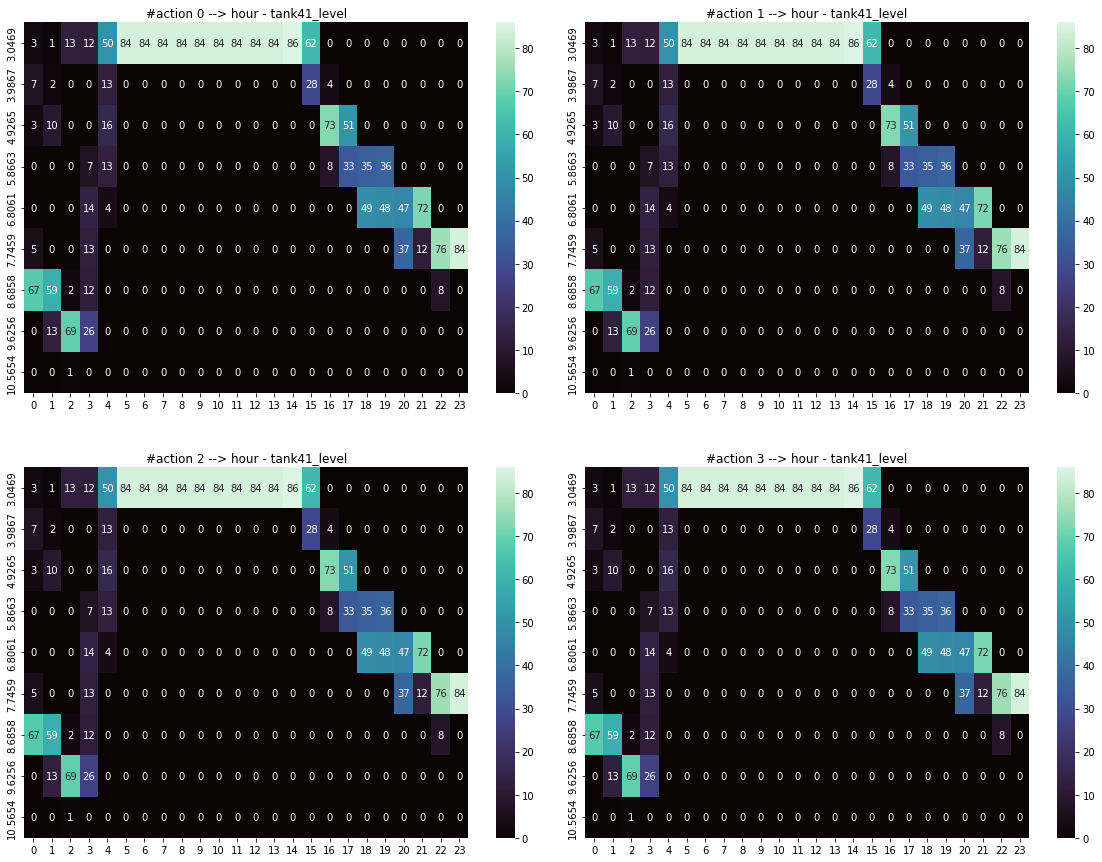

In [249]:
index = [str(round(min_level + int(key) * interval, 4)) for key in count_q_list[0].keys()]
columns = [str(i) for i in range(24)]

figure, axs = plt.subplots(2, 2, figsize=(20,15))
figure.subplots_adjust(hspace = .2, wspace=.01)

axs = axs.ravel()

for i in range(4):
    qs = list(count_q_list[i].values())
    df = pd.DataFrame(qs, index=index, columns=columns)
    sns.heatmap(df, ax=axs[i], cmap='mako',annot=True)
       
axs[0].set_title("#action 0 --> hour - tank41_level")
axs[1].set_title("#action 1 --> hour - tank41_level")
axs[2].set_title("#action 2 --> hour - tank41_level")
axs[3].set_title("#action 3 --> hour - tank41_level")

Let's see which are the action chosen in the different situations by the algorithm.

In [267]:
model = results['eval']
seed = 0

tank41_levels = [model[seed]['dataset']['current_state'][i][2] for i in range(1, len(model[seed]['dataset']))]
max_level = max(tank41_levels)
min_level = min(tank41_levels)
n_intervals = 8

print("min level: ", min_level)
print("max level: ", max_level)

interval = (max_level - min_level) / n_intervals
tmp_dataset = crop_dataset(model, seed).iloc[1:, :]

count_q_list = []

for action in range(4):
    count_q = {str(key): [0] * 24 for key in range(n_intervals + 1)}

    for i in range(len(tmp_dataset)):
        if action == tmp_dataset.iloc[i]['action']:
            mod = str(int((tmp_dataset['current_state'].iloc[i][2] - min_level) // interval))
            hour = int(tmp_dataset['current_state'].iloc[i][1] // 3600)
            count_q[mod][hour] += 1
    
    count_q_list.append(count_q)

min level:  3.0468793
max level:  10.565387


Text(0.5, 1.0, '#action 3 --> hour - tank41_level')

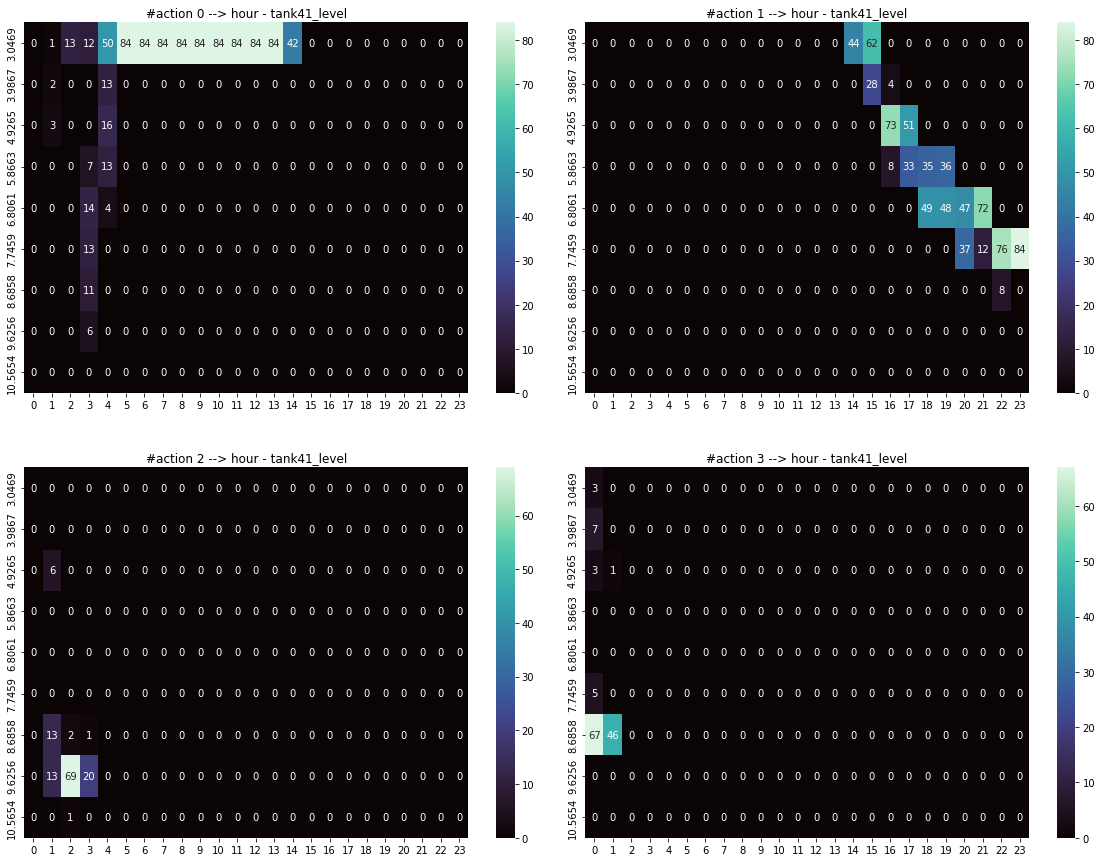

In [268]:
index = [str(round(min_level + int(key) * interval, 4)) for key in count_q_list[0].keys()]
columns = [str(i) for i in range(24)]

figure, axs = plt.subplots(2, 2, figsize=(20,15))
figure.subplots_adjust(hspace = .2, wspace=.01)

axs = axs.ravel()

for i in range(4):
    qs = list(count_q_list[i].values())
    df = pd.DataFrame(qs, index=index, columns=columns)
    sns.heatmap(df, ax=axs[i], cmap='mako',annot=True)
       
axs[0].set_title("#action 0 --> hour - tank41_level")
axs[1].set_title("#action 1 --> hour - tank41_level")
axs[2].set_title("#action 2 --> hour - tank41_level")
axs[3].set_title("#action 3 --> hour - tank41_level")

In [264]:
print(tmp_dataset['action'].to_string())

1       [3]
2       [3]
3       [3]
4       [3]
5       [3]
6       [3]
7       [3]
8       [3]
9       [3]
10      [3]
11      [3]
12      [3]
13      [3]
14      [3]
15      [2]
16      [2]
17      [2]
18      [2]
19      [2]
20      [2]
21      [2]
22      [0]
23      [0]
24      [0]
25      [0]
26      [0]
27      [0]
28      [0]
29      [0]
30      [0]
31      [0]
32      [0]
33      [0]
34      [0]
35      [0]
36      [0]
37      [0]
38      [0]
39      [0]
40      [0]
41      [0]
42      [0]
43      [0]
44      [0]
45      [0]
46      [0]
47      [0]
48      [0]
49      [0]
50      [0]
51      [0]
52      [0]
53      [0]
54      [0]
55      [0]
56      [0]
57      [0]
58      [0]
59      [0]
60      [0]
61      [0]
62      [0]
63      [0]
64      [0]
65      [0]
66      [0]
67      [0]
68      [0]
69      [0]
70      [0]
71      [0]
72      [0]
73      [0]
74      [0]
75      [0]
76      [0]
77      [0]
78      [0]
79      [0]
80      [0]
81      [0]
82      [0]
83      [0]
84  

In [253]:
model = dhalsim_results['eval']
max_qs = []
min_qs = []

for seed in range(5):
    max_qs.append(max([max(model[seed]['q_values'][i][1]) for i in range(len(model[seed]['q_values']))]))
    min_qs.append(min([min(model[seed]['q_values'][i][1]) for i in range(len(model[seed]['q_values']))]))

In [254]:
max_qs, min_qs

([-4.134712219238281,
  -4.134712219238281,
  -4.134712219238281,
  -4.134712219238281,
  -4.134712219238281],
 [-130.91978454589844,
  -131.0349884033203,
  -131.08045959472656,
  -131.0477752685547,
  -131.06158447265625])

In [271]:
model = results['eval']
seed = 0

tank_values = [model[seed]['dataset']['current_state'][i][2] for i in range(len(model[seed]['dataset']))]
tank_values

[0.0,
 3.0484917,
 3.4602926,
 3.857767,
 4.2564244,
 4.601369,
 4.834065,
 4.8560333,
 4.851684,
 4.798853,
 4.884844,
 4.9587092,
 5.039385,
 5.1905622,
 5.3314905,
 5.4053216,
 5.4270205,
 5.480917,
 5.547389,
 5.546979,
 5.5328183,
 5.5945444,
 5.20944,
 5.122911,
 4.755757,
 4.017426,
 3.447526,
 3.277117,
 3.0708055,
 3.0480947,
 3.0480947,
 3.0480947,
 3.0480947,
 3.0480947,
 3.0480947,
 3.0480947,
 3.0480947,
 3.0480947,
 3.0480947,
 3.0480947,
 3.0480947,
 3.0480947,
 3.0480947,
 3.0480947,
 3.0480947,
 3.0480947,
 3.0480947,
 3.0480947,
 3.0480947,
 3.0480947,
 3.0480947,
 3.0480947,
 3.0480947,
 3.0480947,
 3.0480947,
 3.0480947,
 3.0480947,
 3.0480947,
 3.0480947,
 3.0480947,
 3.0480947,
 3.0480947,
 3.0480947,
 3.0480947,
 3.0480947,
 3.0480947,
 3.0480947,
 3.0480947,
 3.0480947,
 3.0480947,
 3.0480947,
 3.0480947,
 3.0480947,
 3.0480947,
 3.0480947,
 3.0480947,
 3.0480947,
 3.0480947,
 3.0480947,
 3.0480947,
 3.0480947,
 3.0480947,
 3.0480947,
 3.0480947,
 3.0480947,
 3.

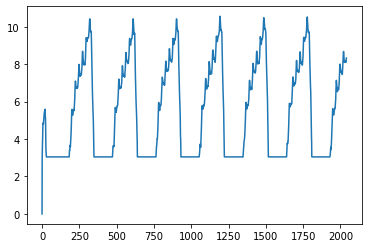

In [272]:
plt.plot(tank_values)

In [257]:
len(model[seed]['dataset']['action'].to_list())

2041

In [258]:
tmp_dataset = crop_dataset(model, seed).iloc[1:, :]
len(tmp_dataset['action'].to_list())

2040